# LegacyHalos SersicFitting

This notebook demonstrates how we fit the 1D surface brightness profiles using various parametric (e.g., Sersic) models, using one galaxy as a toy example.

### Imports, paths, and other preliminaries.

In [1]:
import os 
import numpy as np

from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
import legacyhalos.io
from legacyhalos.qa import display_multiband, display_ellipsefit, display_ellipse_sbprofile
from legacyhalos.ellipse import ellipsefit_multiband
from legacyhalos.ellipse import mgefit_multiband

In [3]:
from photutils.isophote import (EllipseGeometry, Ellipse, EllipseSample,
                                Isophote, IsophoteList)

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [5]:
pixscale = 0.262 # [arcsec/pix] - assume DECam
band = ('g', 'r', 'z')
refband = 'r'

### Read the sample

In [6]:
def read_sample():
    cols = ('ra', 'dec', 'bx', 'by', 'brickname', 'objid', 'type',
            'shapeexp_r', 'shapeexp_e1', 'shapeexp_e2',
            'shapedev_r', 'shapedev_e1', 'shapedev_e2')
    sample = legacyhalos.io.read_catalog(extname='LSPHOT', upenn=True, columns=cols)
        
    rm = legacyhalos.io.read_catalog(extname='REDMAPPER', upenn=True,
                                     columns=('mem_match_id', 'z', 'r_lambda'))
    sample.add_columns_from(rm)

    sample = sample[40]
    print('Read {} galaxies.'.format(len(sample)))
    return sample

In [7]:
sample = read_sample()

Read 1 galaxies.


In [8]:
objid, objdir = legacyhalos.io.get_objid(sample)
redshift = sample.z

### Reproduce ellipse fitting in legacyhalos.ellipse

In [9]:
data = legacyhalos.io.read_multiband(objid, objdir, band=band)
data.keys()

dict_keys(['g', 'g_mask', 'g_masked', 'r', 'r_mask', 'r_masked', 'z', 'z_mask', 'z_masked'])

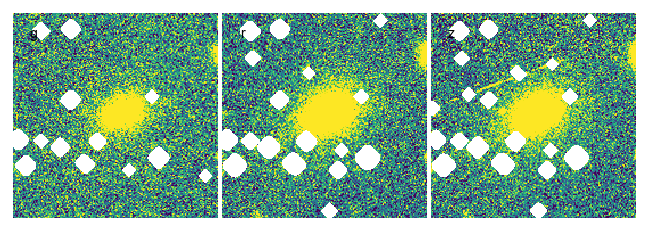

In [10]:
display_multiband(data)

#### Find the galaxy and get basic shape parameters in the reference r-band.

Finding the galaxy in the reference r-band image.
 Pixels used: 2770
 Peak Img[j, k]: 89 89
 Mean (j, k): 91.14 92.75
 Theta (deg): 149.9
 Astro PA (deg): 120.1
 Eps: 0.307
 Major axis (pix): 39.4


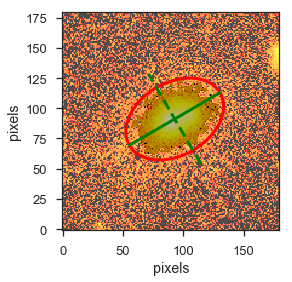

In [11]:
# Find the galaxy and perform MGE fitting
mgefit = mgefit_multiband(objid, objdir, data, band=band, refband=refband,
                          pixscale=pixscale, nofit=True, nowrite=True, 
                          verbose=True, debug=True)

The position angle in photutils is measured counter-clockwise from the x-axis (as documented [here](http://photutils.readthedocs.io/en/stable/api/photutils.isophote.EllipseGeometry.html#photutils.isophote.EllipseGeometry)) while *pa* in MGE is measured counter-clockwise from the y-axis.

In [12]:
geometry = EllipseGeometry(x0=mgefit['xmed'], y0=mgefit['ymed'], 
                           sma=mgefit['majoraxis'], eps=mgefit['eps'], 
                           pa=np.radians(mgefit['pa']-90))
#geometry.find_center(data[refband], verbose=False)
print(geometry.x0, geometry.y0, geometry.sma, geometry.eps, np.degrees(geometry.pa))

91.1372324699 92.7455373709 39.4440592396 0.306927156317 30.1052383115


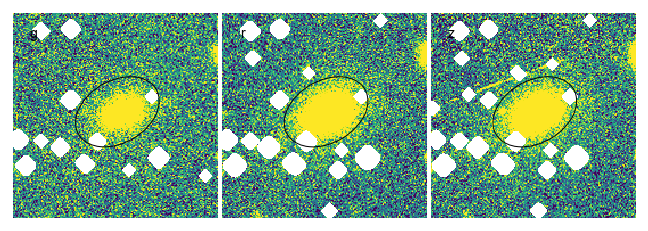

In [13]:
display_multiband(data, geometry=geometry)

In [14]:
ellipsefit = ellipsefit_multiband(objid, objdir, data, mgefit, band=band, 
                                  refband=refband, nowrite=True)

In [15]:
ellipsefit[refband].to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,0.354346673772,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.507627989974,0.35356582721,0.000696585806946,0.133408489325,0.0101288942505,39.903882967668714,2.488634604657507,None,13,0,1,5
0.558390788971,0.353159969451,0.000853025929951,0.133408489325,0.0274035540187,39.903882967668714,6.732904658790617,2.30937349966,13,0,1,5
0.614229867868,0.353829704855,0.000340875950751,0.168519053984,0.0268952725532,57.32810434871685,5.331590508824679,0.487531500621,13,0,10,0
0.675652854655,0.353092732821,0.000396141679754,0.151494596829,0.0236933592059,44.2882923147451,5.1822982327244835,0.402680012811,13,0,10,0
0.743218140121,0.351791801211,0.000458654898967,0.153822427967,0.0232384602088,41.14442860239894,5.016254775726548,0.405351376077,13,0,10,0
0.817539954133,0.350004732385,0.000552307555393,0.147801757147,0.0216642904736,40.187267081017005,4.84085840726046,0.338238592134,13,0,10,0
0.899293949546,0.347087647162,0.000589963482647,0.104010832912,0.020369524818,33.30348243708657,6.320662570933914,0.29056663724,13,0,10,0


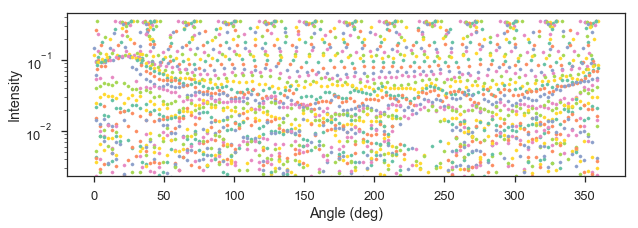

In [16]:
isos = ellipsefit['r']
fig, ax = plt.subplots(figsize=(10, 3))
for iso in isos:
    angles = ( np.degrees(iso.sample.values[0] + iso.sample.geometry.pa) ) % 360.
    ax.scatter(angles, iso.sample.values[2], s=10)
ax.set_xlabel('Angle (deg)')
ax.set_ylabel('Intensity')
ax.set_yscale('log')

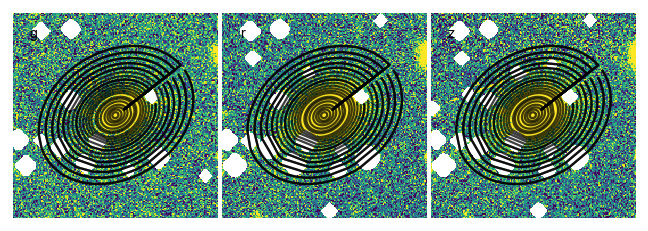

In [17]:
display_multiband(data, ellipsefit=ellipsefit)

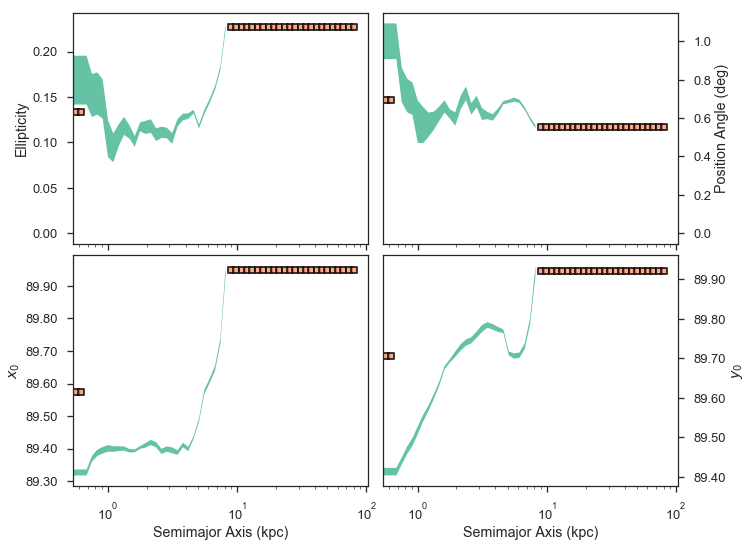

In [18]:
display_ellipsefit(ellipsefit, band=band, refband=refband, redshift=redshift, 
                   pixscale=pixscale, xlog=True)

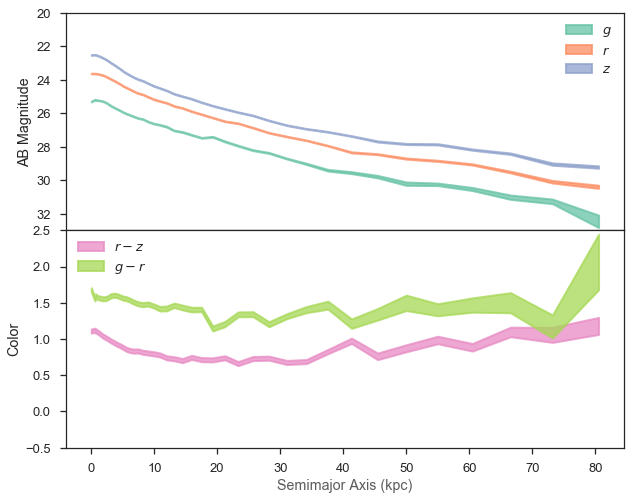

In [19]:
display_ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                          redshift=redshift, pixscale=pixscale)

### Playing around below here

In [20]:
stop

NameError: name 'stop' is not defined

In [ ]:
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
smascale = 1
filt = 'r'
good = (ellipsefit[filt].stop_code < 4)
bad = ~good
fig, ax1 = plt.subplots()
ax1.fill_between(ellipsefit[filt].sma[good] * smascale, 
                 ellipsefit[filt].eps[good]-ellipsefit[filt].ellip_err[good],
                 ellipsefit[filt].eps[good]+ellipsefit[filt].ellip_err[good],
                 edgecolor='k', lw=2)

#ax1.errorbar(ellipsefit[filt].sma[good] * smascale,
#             ellipsefit[filt].eps[good],
#             ellipsefit[filt].ellip_err[good], marker='s', linestyle='none',
#             capsize=10, capthick=2, 
#             markersize=10)#, color=color[filt])
ax1.scatter(ellipsefit[filt].sma[bad] * smascale,
             ellipsefit[filt].eps[bad], marker='s', s=40, edgecolor='k', lw=2, alpha=0.75)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())